In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime as dt
from collections import namedtuple
import swifter # "pip install swifter" if no package

# Functions

In [10]:
def parse_mi_ho(f):

    df = pd.read_csv(f)
    df["Timestamp"] = df["Timestamp"].swifter.apply(lambda x: pd.to_datetime(x) + dt.timedelta(hours=8)) 
    nr_pci = 'O'
    scells = []

    def NR_OTA(idx):

        if df["type_id"].iloc[idx] == "5G_NR_RRC_OTA_Packet": return True
        else: return False
    
    def LTE_SERV_INFO(idx):

        if df["type_id"].iloc[idx] == "LTE_RRC_Serv_Cell_Info": return True
        else: return False
    

    def find_1st_after(start_idx, target, look_after=1):
        for j in range(start_idx, len(df)):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t_ - t).total_seconds() > look_after:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before(start_idx, target, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] not in [0,'0'] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_1st_before_with_special_value(start_idx, target, target_value, look_before=1):
        for j in range(start_idx, -1, -1):
            t_ = df["Timestamp"].iloc[j]
            if NR_OTA(j) or LTE_SERV_INFO(j):
                continue
            if (t - t_).total_seconds() > look_before:
                return None, None
            if df[target].iloc[j] in [target_value] and not np.isnan(df[target].iloc[j]):
                return t_, j
        return None, None
    
    def find_in_D_exact(targets):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.start).total_seconds(), target))

        if len(l) != 0:
            for x in l:
                if (x[0]== 0):
                    return x[1]
        
        return None
    
    def find_in_D_first_before(targets, look_before=1):

        l = []
        # In l : (second, ho_type)
        for target in targets:
            for ho in D[target]:
                l.append(((t - ho.end).total_seconds(), target, ho))

        if len(l) != 0:
            closest = min(filter(lambda x: x[0] > 0, l), key=lambda x: x[0])
            if 0 <= closest[0] < look_before:
                return closest[1], closest[2]
        
        return None, None

    HO = namedtuple('HO',['start', 'end', 'others', 'trans'], defaults=[None,None,'',''])
    
    D = {
        'Conn_Rel':[], 
        'Conn_Req':[], # Setup
        'LTE_HO': [], # LTE -> newLTE
        'MN_HO': [], # LTE + NR -> newLTE + NR
        'MN_HO_to_eNB': [], # LTE + NR -> newLTE
        'SN_setup': [], # LTE -> LTE + NR => NR setup
        'SN_Rel': [], # LTE + NR -> LTE
        'SN_HO': [], # LTE + NR -> LTE + newNR  
        'RLF_II': [],
        'RLF_III': [],
        'SCG_RLF': [],
        'Add_SCell': [],
        }
    
    for i in range(len(df)):

        # Pass NR RRC packet. In NSA mode, LTE RRC packet include NR packet message.
        if NR_OTA(i) or LTE_SERV_INFO(i):
            continue

        try: lte_pci, lte_earfcn
        except: 
            lte_pci = df["PCI"].iloc[i]
            lte_earfcn = int(df["Freq"].iloc[i])

        others = ''
        t = df["Timestamp"].iloc[i]

        if df["rrcConnectionRelease"].iloc[i] == 1:
            D['Conn_Rel'].append(HO(start=t))
            nr_pci = 'O'

        if df["rrcConnectionRequest"].iloc[i] == 1:
            
            # Define end of rrcConnectionRequest to be rrcConnectionReconfigurationComplete or securityModeComplete.
            a = find_1st_after(i, 'rrcConnectionReconfigurationComplete',look_after=2)[0]
            b = find_1st_after(i, 'securityModeComplete',look_after=2)[0]
        
            if a is None and b is None: end = None
            elif a is None and b is not None: end = b
            elif a is not None and b is None: end = a 
            else: end = a if a > b else b
            
            _, idx = find_1st_after(i, 'ueCapabilityInformation',look_after=1)
            if idx is not None:
                sup_band = df['bandEUTRA'].iloc[idx]
                others += f' supported band: {sup_band}.' 

            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            trans = f'({lte_pci}, {lte_earfcn}) -> ({serv_cell}, {serv_freq})'
            
            # Check if caused by RLF III.
            a, idx = find_1st_before(i, 'rrcConnectionReestablishmentReject', look_before=1)
            if a is not None:
                others += ' After RLF III.'

            D['Conn_Req'].append(HO(start=t,end=end,trans=trans, others=others))

            nr_pci = 'O'
            lte_pci = serv_cell
            lte_earfcn = serv_freq
            
        if df["lte-rrc.t304"].iloc[i] == 1:
            
            end, _ = find_1st_after(i, 'rrcConnectionReconfigurationComplete')
            serv_cell, target_cell = df["PCI"].iloc[i], int(df['lte_targetPhysCellId'].iloc[i])
            serv_freq, target_freq = int(df["Freq"].iloc[i]), int(df['dl-CarrierFreq'].iloc[i])

            lte_pci = target_cell
            lte_earfcn = target_freq

            if df["SCellToAddMod-r10"].iloc[i] == 1:
                n =len(str(df["SCellIndex-r10.1"].iloc[i]).split('@'))
                others += f' Set up {n} SCell.'
            else:
                scells = []
            
            if serv_freq != target_freq:
                a,b = find_1st_before(i, "rrcConnectionReestablishmentRequest", 1)
                others += " Inter frequency HO."
                if a is not None:
                    others += " Near after RLF."
                
            if df["nr-rrc.t304"].iloc[i] == 1 and df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 2)
                    
                    if a is not None:

                        ho_type, ho = find_in_D_first_before(['RLF_II', 'RLF_III'], 2)
                        others += f' Near after RLF of trans: {ho.trans}.'

                    else:
                        
                        ho_type, _ = find_in_D_first_before(['MN_HO_to_eNB', 'SN_Rel'], 2)
                        if ho_type is not None:
                            others += f' Near after {ho_type}.'

                    ori_serv = nr_pci
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) | {ori_serv} -> {nr_pci}'
                    D['SN_setup'].append(HO(start=t, end=end, others=others, trans=trans))

                else:
                    
                    nr_pci = int(df['nr_physCellId'].iloc[i])
                    trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                    D['MN_HO'].append(HO(start=t, end=end, others=others, trans=trans))

            else:
                
                if serv_cell == target_cell and serv_freq == target_freq:

                    a, b = find_1st_before(i, "scgFailureInformationNR-r15")
                    if a is not None:
                        others += " Caused by scg-failure."
                    
                    orig_serv = nr_pci
                    nr_pci = 'O'
                    trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                    D['SN_Rel'].append(HO(start=t, end=end, others=others, trans=trans))
                    
                else:

                    a, _ = find_1st_before(i,"rrcConnectionSetup",3)
                    if a is not None:
                        others += ' Near After connection setup.'
                    if nr_pci == 'O':
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {nr_pci}'
                        D['LTE_HO'].append(HO(start=t, end=end, others=others, trans=trans))
                    else:
                        orig_serv = nr_pci
                        nr_pci = 'O'
                        trans = f'({serv_cell}, {serv_freq}) -> ({target_cell}, {target_freq}) | {orig_serv} -> {nr_pci}'
                        D['MN_HO_to_eNB'].append(HO(start=t, end=end, others=others, trans=trans))


        if df["nr-rrc.t304"].iloc[i] == 1 and not df["dualConnectivityPHR: setup (1)"].iloc[i] == 1:

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
        
            serv_cell, serv_freq = df["PCI"].iloc[i], int(df["Freq"].iloc[i])
            orig_serv = nr_pci
            nr_pci = int(df['nr_physCellId'].iloc[i])
            trans = f'({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
            D['SN_HO'].append(HO(start=t,end=end,trans=trans))


        if df["rrcConnectionReestablishmentRequest"].iloc[i] == 1:

            end1, _ = find_1st_after(i, 'rrcConnectionReestablishmentComplete', look_after=1)
            b, _ = find_1st_after(i, 'rrcConnectionReestablishmentReject', look_after=1)
            end2, _ = find_1st_after(i, 'securityModeComplete',look_after=3)

            others += ' ' + df["reestablishmentCause"].iloc[i] + '.'
            scells = []

            c, _ = find_1st_before(i, 'scgFailureInformationNR-r15', 1)
            if c != None:
                others  += ' caused by scgfailure.'
                
            serv_cell, rlf_cell = df["PCI"].iloc[i], int(df['physCellId.3'].iloc[i])
            serv_freq = int(df['Freq'].iloc[i])
            
            # Type II & Type III
            if end1 is not None: 

                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])
                trans = f'({rlf_cell}, {rlf_freq}) -> ({serv_cell}, {serv_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_II'].append(HO(start=t,end=end1,others=others,trans=trans))

                lte_pci = serv_cell
                lte_earfcn = serv_freq

            elif b is not None and end2 is not None:
                
                orig_serv = nr_pci
                nr_pci = 'O'
                _, idx = find_1st_before_with_special_value(i, 'PCI', rlf_cell, look_before=10)
                rlf_freq = int(df['Freq'].iloc[idx])

                _, idx = find_1st_after(i, "rrcConnectionRequest", 2)
                recon_cell, recon_freq = df['PCI'].iloc[idx], int(float(df['Freq'].iloc[idx]))
                
                trans = f'({rlf_cell}, {rlf_freq}) -> ({recon_cell}, {recon_freq}) | {orig_serv} -> {nr_pci}'
                D['RLF_III'].append(HO(start=t,end=end2,others=others,trans=trans)) 

                # lte_pci, lte_earfcn will be updated in rrcConnectionRequest.     
                
            else:

                others+=' No end.'
                D['RLF_II'].append(HO(start=t,others=others))
                print('No end for RLF')

        if df["scgFailureInformationNR-r15"].iloc[i] == 1:

            others += ' ' + df["failureType-r15"].iloc[i] + '.'
            a, idx1 = find_1st_after(i, "rrcConnectionReestablishmentRequest", look_after=1)
            b, idx2 = find_1st_after(i, "lte-rrc.t304", look_after=10)

            if a is not None:

                end1, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentComplete', look_after=1)
                b, _ = find_1st_after(idx1, 'rrcConnectionReestablishmentReject', look_after=1)
                end2 = find_1st_after(idx1, 'securityModeComplete',look_after=3)[0]

                others += ' Result in rrcReestablishment.'
                    
                # Type II & Type III Result
                if end1 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end1,others=others))
                elif b is not None and end2 is not None: 
                    D['SCG_RLF'].append(HO(start=t,end=end2,others=others))
                else:
                    others += ' No end.'
                    D['SCG_RLF'].append(HO(start=t,others=others))
                    print('No end for scg failure result in rrcReestablishment.')

            elif b is not None:

                end, _ = find_1st_after(idx2, 'rrcConnectionReconfigurationComplete')
                serv_cell, target_cell = df["PCI"].iloc[idx2], df['lte_targetPhysCellId'].iloc[idx2]
                serv_freq, target_freq = int(df["Freq"].iloc[idx2]), df['dl-CarrierFreq'].iloc[idx2]
                # We do not change nr_pci here. Instead, we will change it at gNB_Rel event.
                trans = f'({serv_cell}, {serv_freq}) | {nr_pci} -> O'
                
                if serv_cell == target_cell and serv_freq == target_freq:
                    others += ' Result in gNB release.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))
                else:
                    others += ' Result in MN HO to eNB.'
                    D['SCG_RLF'].append(HO(start=t,end=end,others=others,trans=trans))                  

            else:

                print('No end for scg failure.')
                others += ' No end.'
                D['SCG_RLF'].append(HO(start=t,others=others))
        
        if df['SCellToAddMod-r10'].iloc[i] == 1 and df['physCellId-r10'].iloc[i] != 'nr or cqi report':

            others = ''
            pcis = str(df["physCellId-r10"].iloc[i]).split('@')
            freqs = str(df["dl-CarrierFreq-r10"].iloc[i]).split('@')
            orig_scells = scells
            scells = [(int(float(pci)), int(float(freq))) for pci, freq in zip(pcis, freqs)]

            others += f' Set up {len(scells)} SCell.'
            trans = f'{orig_scells} -> {scells}'

            end, _ = find_1st_after(i,'rrcConnectionReconfigurationComplete')
            
            a, _ = find_1st_before(i, "rrcConnectionReestablishmentRequest", 3)
            if a is not None:
                others += ' Near after RLF.'

            a = find_in_D_exact(['LTE_HO', 'MN_HO', 'MN_HO_to_eNB', 'SN_setup', 'SN_Rel'])
            if a is not None:
                others += f' With {a}.'

            D['Add_SCell'].append(HO(start=t,end=end,others=others, trans=trans))
    
    return D


# TCP

In [ ]:
# Read file
server_pcap = '/home/wmnlab/Data/23-3-4-19-52_server_pcap.csv'
s_df = pd.read_csv(server_pcap, sep='@')
s_df["frame.time"] = pd.to_datetime(s_df["frame.time"])

client_pcap = '/home/wmnlab/Data/23-3-4-19-52_client_pcap.csv'
c_df = pd.read_csv(client_pcap, sep='@')
c_df["frame.time"] = pd.to_datetime(c_df["frame.time"])

In [ ]:
# Plot DL packet RTT -> For DL, we check server end pcap file
df = s_df[s_df['tcp.dstport'] == 3251]
plt.plot(df['frame.time'], df['tcp.analysis.ack_rtt']*1000)
plt.title('DL RTT')
plt.ylabel('RTT (ms)')
plt.xlabel('Time')

In [ ]:
# Plot UL packet RTT -> For UL, we check client end pcap file
df = c_df[c_df['tcp.srcport'] == 3250]
plt.plot(df['frame.time'], df['tcp.analysis.ack_rtt']*1000)
plt.title('UL RTT')
plt.ylabel('RTT (ms)')
plt.xlabel('Time')

# Example

In [ ]:
# Read DL file
dl_file = '/home/wmnlab/Templates/example/UDP_Bandlock_8_Phone/sm00/#01/data/udp_dnlk_loss_latency.csv'
dl_df = pd.read_csv(dl_file)
dl_df['Timestamp'] = pd.to_datetime(dl_df['Timestamp'])

In [11]:
# Get HO times.
rrc_file = '/home/wmnlab/D/database/2023-12-26/Modem_Action_Test_v2_1/qc00/#01/data/diag_log_qc00_2023-12-26_15-01-07_rrc.csv'
hos = parse_mi_ho(rrc_file)

In [ ]:
Timestamps = dl_df['Timestamp']
lats = dl_df['latency']

target = hos['LTE_HO'] + hos['MN_HO'] + hos['MN_HO_to_eNB']
target_times = [h.start for h in target]
plt.scatter(target_times, [0.2] * len(target_times), marker='o', color='g', label='4G HO', s=30)

target = hos['SN_HO'] + hos['SN_Rel'] + hos['SN_setup']
target_times = [h.start for h in target]
plt.scatter(target_times, [0.2] * len(target_times), marker='*', color='y', label='5G HO', s=30)

target = hos['RLF_II'] + hos['RLF_III']
target_times = [h.start for h in target]
plt.scatter(target_times, [0.2] * len(target_times), marker='s', color='r', label='RLF', s=30)

plt.plot(Timestamps, lats)

plt.xlabel('Time')
plt.ylabel('Latency (sec)')
plt.legend()

plt.gcf().autofmt_xdate()

plt.show()

## Signal Strength

### LTE

In [25]:
SS = namedtuple('SS', ['PCI', 'earfcn', 'RSRP', 'RSRQ', 'Timestamp'], defaults=['','',0,0,None])

def LTE_signal_strength(ml1_file, time_range):
    # Read csv with pandas
    ml1_df = pd.read_csv(ml1_file)
    ml1_df['Timestamp'] = pd.to_datetime(ml1_df['Timestamp'])
    ml1_df['Timestamp'] = ml1_df['Timestamp'] + pd.Timedelta(hours=8)
    ml1_df = ml1_df.astype({'PCI': str, 'EARFCN': str})

    # Read ml1 csv data
    Cells = {}
    PCell = []
    SCell1, SCell2, SCell3 = [], [], []

    start_time = time_range[0]
    end_time = time_range[1]

    for i in range(len(ml1_df)):

        t = ml1_df['Timestamp'].iloc[i]
        if t < start_time: continue
        elif start_time <= t < end_time: pass
        elif end_time <= t: break

        serv_cell_idx = ml1_df['Serving Cell Index'].iloc[i]
        pci = ml1_df['PCI'].iloc[i]
        earfcn = ml1_df['EARFCN'].iloc[i]
        rsrp = ml1_df['RSRP(dBm)'].iloc[i]
        rsrq = ml1_df['RSRQ(dB)'].iloc[i]

        ss = SS(pci, earfcn, rsrp, rsrq, t)
        
        if serv_cell_idx == 'PCell':
            PCell.append(ss)
        elif serv_cell_idx == '1_SCell':
            SCell1.append(ss)
        elif serv_cell_idx == '2_SCell':
            SCell2.append(ss)
        elif serv_cell_idx == '(MI)Unknown':
            SCell3.append(ss)

        k = pci+' '+earfcn 
        if k in Cells.keys():
            Cells[k].append(ss)
        else:
            Cells[k] = [ss]

        # Cells
        num_neicells = ml1_df['Number of Neighbor Cells'].iloc[i]
        
        for j in np.arange(9, 9+num_neicells*3,3):
            pci = str(int(ml1_df.iloc[i][j]))
            rsrp = ml1_df.iloc[i][j+1]
            rsrq = ml1_df.iloc[i][j+2]
            ss = SS(pci, earfcn, rsrp, rsrq, t)
            k = pci+' '+earfcn 

            if k in Cells.keys():
                Cells[k].append(ss)
            else:
                Cells[k] = [ss]
    
    return PCell, SCell1, SCell2, SCell3, Cells

In [27]:
ml1_file = '/home/wmnlab/D/database/2023-12-26/Modem_Action_Test_v2_1/qc00/#01/data/diag_log_qc00_2023-12-26_15-01-07_ml1.csv'
start_time = dt.datetime(2023, 12, 26, 15, 1, 10)
end_time = dt.datetime(2023, 12, 26, 15, 1, 20)
time_range = [start_time, end_time]

PCell, SCell1, SCell2, SCell3, Cells = LTE_signal_strength(ml1_file, time_range)

In [30]:
# Select plot target
targets = [PCell, SCell1, SCell2, SCell3]
names = ['PCell', 'SCell1', 'SCell2', 'SCell3']

ts = []
rsrps = []
rsrqs = []

for target in targets:
 
    t = []
    rsrp, rsrq = [], []
 
    for ss in target:
        rsrp.append(ss.RSRP)
        rsrq.append(ss.RSRQ)
        t.append(ss.Timestamp)
    
    ts.append(t)
    rsrps.append(rsrp)
    rsrqs.append(rsrq)


# Given PCI and plot
targets = []
ts2 = []
rsrps2 = []
rsrqs2 = []

for target in targets:
    cell = Cells[target]
    t = []
    rsrp, rsrq = [], []
    for ss in cell:
        t.append(ss.Timestamp)
        rsrp.append(ss.RSRP)
        rsrq.append(ss.RSRQ)
    ts2.append(t)
    rsrps2.append(rsrp)
    rsrqs2.append(rsrq)

In [31]:
# Select special event
hos = parse_mi_ho(rrc_file)
special_events = hos['RLF_II'] + hos['RLF_III']
special_events

[]

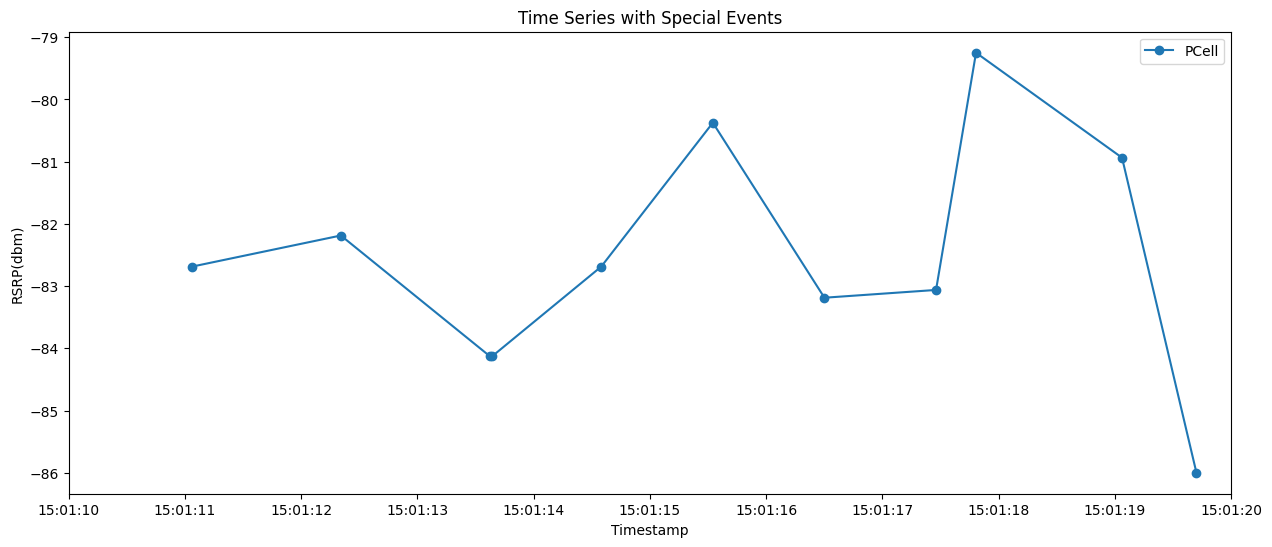

In [32]:
plt.figure(figsize=(15, 6))

labels = ['PCell'] + ['RLF']

for t, rsrp, rsrq, label in zip(ts, rsrps, rsrqs, names):
    if label == 'PCell':
        plt.plot(t, rsrp, marker='o', label=label)

# for t, rsrp, rsrq, label in zip(ts2, rsrps2, rsrqs2, targets):
#     plt.plot(t, rsrp, marker='o', label=label)

for event in special_events:
    event_time = event.start
    plt.axvline(event_time, color='r', linestyle='--', linewidth=2, label='RLF')


start_time = dt.datetime(2023, 12, 26, 15, 1, 10)
end_time = dt.datetime(2023, 12, 26, 15, 1, 20)
plt.xlim((start_time, end_time))

plt.xlabel('Timestamp')
plt.ylabel('RSRP(dbm)')
plt.title('Time Series with Special Events')
plt.legend(labels)

plt.show()

### NR

In [52]:
SS = namedtuple('SS', ['PCI', 'earfcn', 'RSRP', 'RSRQ', 'Timestamp'], defaults=['','',0,0,None])

def NR_signal_strength(ml1_file, time_range):
    # Read csv with pandas
    ml1_df = pd.read_csv(ml1_file)
    ml1_df['Timestamp'] = pd.to_datetime(ml1_df['Timestamp'])
    ml1_df['Timestamp'] = ml1_df['Timestamp'] + pd.Timedelta(hours=8)
    ml1_df = ml1_df.astype({'Serving Cell PCI': str, 'Raster ARFCN': str})

    Cells = {}
    PSCell = []

    start_time = time_range[0]
    end_time = time_range[1]

    for i in range(len(ml1_df)):

        t = ml1_df['Timestamp'].iloc[i]
        if t < start_time: continue
        elif start_time <= t < end_time: pass
        elif end_time <= t: break

        PSCell_pci = ml1_df['Serving Cell PCI'].iloc[i]
        earfcn = ml1_df['Raster ARFCN'].iloc[i]

        # Deal with Cells first        
        for j in np.arange(6, len(ml1_df.columns),3):
            if np.isnan(ml1_df.iloc[i][j]):
                break
            pci = str(int(ml1_df.iloc[i][j]))
            rsrp = ml1_df.iloc[i][j+1]
            rsrq = ml1_df.iloc[i][j+2]
            ss = SS(pci, earfcn, rsrp, rsrq, t)
            k = pci+' '+earfcn 

            if k in Cells.keys():
                Cells[k].append(ss)
            else:
                Cells[k] = [ss]

        # Deal with PSCell
        if PSCell_pci == '65535':
            continue
        ss = Cells[PSCell_pci+' '+earfcn][-1]
        PSCell.append(ss)
        
    
    return PSCell, Cells

In [54]:
start_time = dt.datetime(2023, 12, 26, 15, 1, 10)
end_time = dt.datetime(2023, 12, 26, 15, 1, 20)
time_range = [start_time, end_time]
PSCell, Cells = NR_signal_strength(ml1_file, time_range)

In [55]:
PSCell

[SS(PCI='178', earfcn='630912', RSRP=-75.734, RSRQ=-11.57, Timestamp=Timestamp('2023-12-26 15:01:10.031703')),
 SS(PCI='178', earfcn='630912', RSRP=-75.352, RSRQ=-11.453, Timestamp=Timestamp('2023-12-26 15:01:10.191701')),
 SS(PCI='178', earfcn='630912', RSRP=-75.484, RSRQ=-11.414, Timestamp=Timestamp('2023-12-26 15:01:10.351698')),
 SS(PCI='178', earfcn='630912', RSRP=-75.242, RSRQ=-11.414, Timestamp=Timestamp('2023-12-26 15:01:10.511702')),
 SS(PCI='178', earfcn='630912', RSRP=-75.211, RSRQ=-11.414, Timestamp=Timestamp('2023-12-26 15:01:10.671699')),
 SS(PCI='178', earfcn='630912', RSRP=-75.422, RSRQ=-11.414, Timestamp=Timestamp('2023-12-26 15:01:10.831699')),
 SS(PCI='178', earfcn='630912', RSRP=-75.219, RSRQ=-11.461, Timestamp=Timestamp('2023-12-26 15:01:10.991696')),
 SS(PCI='178', earfcn='630912', RSRP=-74.688, RSRQ=-11.406, Timestamp=Timestamp('2023-12-26 15:01:11.151700')),
 SS(PCI='178', earfcn='630912', RSRP=-74.453, RSRQ=-11.414, Timestamp=Timestamp('2023-12-26 15:01:11.3116